In [5]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


In [70]:
def get_facts(cik: str, user_agent: str) -> dict:
    """A few quarters of financial reports."""
    assert len(cik) == 10
    url_facts = "https://data.sec.gov/api/xbrl/companyfacts/"
    headers = {"User-Agent": user_agent}
    resp = requests.get(url_facts + "CIK" + cik + ".json", headers=headers, timeout=5)
    resp_json = None
    if resp.status_code < 400:
        resp_json = resp.json()
    return resp_json


def get_submissions(cik: str, user_agent: str) -> dict:
    """History of submissions of financial report fillings."""
    assert len(cik) == 10
    url_submissions = "https://data.sec.gov/submissions/"
    headers = {"User-Agent": user_agent}
    try:
        resp = requests.get(
            url_submissions + "CIK" + cik + ".json", headers=headers, timeout=5
        )
    except:
        return None

    resp_json = None
    if resp.status_code < 400:
        resp_json = resp.json()
    return resp_json


def get_concepts(cik: str, entry: str, user_agent: str, taxonomy="us-gaap") -> dict:
    """hisotry of values for a specific financial report entry (e.g. Revenues)
    for a specific company.
    """
    assert len(cik) == 10
    url_concepts = "https://data.sec.gov/api/xbrl/companyconcepts/"
    headers = {"User-Agent": user_agent}
    resp = requests.get(
        url_concepts + "CIK" + cik + "/" + taxonomy + "/" + entry + ".json",
        headers=headers,
        timeout=5,
    )


def get_frames(
    cik: str,
    entry: str,
    period: str,
    currency: str,
    user_agent: str,
    taxonomy="us-gaap",
) -> dict:
    """"""
    assert len(cik) == 10
    url_frames = "https://data.sec.gov/api/xbrl/frames"
    headers = {"User-Agent": user_agent}
    resp = requests.get(
        f"{url_frames}/CIK{cik}/{taxonomy}/{entry}/{currency}/CY{period}.json",
        headers=headers,
        timeout=5,
    )


def format_cik(cik: int) -> str:
    return f"{cik:010d}"

In [2]:
import pandas as pd
import requests
import json
import time
from tqdm import tqdm
from zipfile import ZipFile

In [7]:
# take a look at the data

# date from company.idx on the SEC website
file_companies_2005_Q1 = "../data/raw/company_2005_Q1.zip"
file_companies_2011_Q4 = "../data/raw/company_2011_Q4.zip"

myzip = ZipFile(file_companies_2005_Q1)
#     print(myzip.namelist())
filestream_2005 = myzip.open("company.idx")
myzip.close()

myzip = ZipFile(file_companies_2011_Q4)
filestream_2011 = myzip.open("company.idx")
myzip.close()

In [8]:
# load company list data
df_2005 = pd.read_csv(
    filestream_2005,
    sep=r" [ ]+",
    header=4,
    skiprows=[8],
    error_bad_lines=False,
    warn_bad_lines=False,
)
df_2005.info()

/Users/navy/anaconda3/envs/propulsion/lib/python3.9/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)
/Users/navy/anaconda3/envs/propulsion/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/navy/anaconda3/envs/propulsion/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314826 entries, 0 to 314825
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Company Name  314826 non-null  object 
 1   Form Type     314825 non-null  object 
 2   CIK           314825 non-null  float64
 3   Date Filed    314825 non-null  object 
 4   File Name     314825 non-null  object 
dtypes: float64(1), object(4)
memory usage: 12.0+ MB


In [10]:
# load company list data
df_2011 = pd.read_csv(
    filestream_2011,
    sep=r" [ ]+",
    header=4,
    skiprows=[9],
    error_bad_lines=False,
    warn_bad_lines=False,
    encoding_errors="replace",
)
df_2011.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202470 entries, 0 to 202469
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Company Name  202470 non-null  object
 1   Form Type     202470 non-null  object
 2   CIK           202470 non-null  int64 
 3   Date Filed    202470 non-null  object
 4   File Name     202470 non-null  object
dtypes: int64(1), object(4)
memory usage: 7.7+ MB


In [11]:
# cleaning


def to_int(x):
    try:
        return int(x)
    except (pd.errors.IntCastingNaNError, ValueError):
        return -1


# 2005
df_2005["CIK"] = df_2005["CIK"].apply(lambda x: to_int(x))
df_2005["Date_filed"] = pd.to_datetime(df_2005["Date Filed"])
df_2005["Form Type"] = df_2005["Form Type"].astype("category")

# 2011
df_2011["Date_filed"] = pd.to_datetime(df_2011["Date Filed"])
df_2011["Form Type"] = df_2011["Form Type"].astype("category")

df_2005.to_csv("../data/processed/companies_2005_Q1.csv")
df_2011.to_csv("../data/processed/companies_2011_Q4.csv")

In [12]:
# select only 10-Q fillings

# some companies didn't fill 10-Q (why??), for instance AMAZON INC COM
df_2005_10Q = df_2005[df_2005["Form Type"].isin(["10-Q", "10-K"])]
df_2011_10Q = df_2011[df_2011["Form Type"].isin(["10-Q", "10-K"])]
print(df_2005_10Q.shape, df_2011_10Q.shape)

df_2005_10Q.drop_duplicates("Company Name", inplace=True)
df_2011_10Q.drop_duplicates("Company Name", inplace=True)
print(df_2005_10Q.shape, df_2011_10Q.shape)

(8272, 6) (8461, 6)
(7984, 6) (7984, 6)


/Users/navy/anaconda3/envs/propulsion/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [13]:
counts = df_2005_10Q.value_counts("Company Name")
print(sum(counts > 1) / len(counts))
counts

0.0


Company Name
1 800 CONTACTS INC                      1
PALL CORP                               1
PANHANDLE ROYALTY CO                    1
PANHANDLE EASTERN PIPE LINE CO LP       1
PANERA BREAD CO                         1
                                       ..
FIRST NATIONAL LINCOLN CORP /ME/        1
FIRST NATIONAL FUNDING LLC              1
FIRST NATIONAL CORP /VA/                1
FIRST NATIONAL COMMUNITY BANCORP INC    1
streetTRACKS GOLD TRUST                 1
Length: 7984, dtype: int64

In [14]:
counts = df_2011_10Q.value_counts("Company Name")
print(sum(counts > 1) / len(counts))
counts

0.0


Company Name
'mktg, inc.'                  1
Ocean Shore Holding Co.       1
OmniaLuo, Inc.                1
OmniAmerican Bancorp, Inc.    1
Omega Flex, Inc.              1
                             ..
Enhance Skin Products Inc     1
Engraving Masters, Inc.       1
Engchow Education Corp        1
Enertopia Corp.               1
vitaminspice                  1
Length: 7984, dtype: int64

In [15]:
# What's happening with this company... ?
df_2011_10Q[df_2011_10Q["Company Name"] == "Grupo International Inc"]

,Company Name,Form Type,CIK,Date Filed,File Name,Date_filed
81954,Grupo International Inc,10-K,1082576,2011-10-19,edgar/data/1082576/0001269678-11-000230.txt,2011-10-19


In [16]:
# Select only companies (a bit rough...)

is_company = ["INC", "Inc", "CORP", "LTD", "Corp", "CO", "inc"]
df_2005_10Q_inc = df_2005_10Q[
    df_2005_10Q["Company Name"].str.contains("|".join(is_company))
]
df_2011_10Q_inc = df_2011_10Q[
    df_2011_10Q["Company Name"].str.contains("|".join(is_company))
]

In [17]:
# Check the remaining entries

df_2005_10Q_fund = df_2005_10Q[
    ~df_2005_10Q["Company Name"].str.contains("|".join(is_company))
]
df_2011_10Q_fund = df_2011_10Q[
    ~df_2011_10Q["Company Name"].str.contains("|".join(is_company))
]
df_2005_10Q_fund
df_2011_10Q_fund

,Company Name,Form Type,CIK,Date Filed,File Name,Date_filed
452,99 CENTS ONLY STORES,10-Q,1011290,2011-11-10,edgar/data/1011290/0001140361-11-052840.txt,2011-11-10
585,AAA CAPITAL ENERGY FUND L.P.,10-Q,1057051,2011-11-14,edgar/data/1057051/0000950123-11-098443.txt,2011-11-14
587,AAA CAPITAL ENERGY FUND L.P. II,10-Q,1227268,2011-11-14,edgar/data/1227268/0000950123-11-098383.txt,2011-11-14
704,ABBOTT LABORATORIES,10-Q,1800,2011-11-04,edgar/data/1800/0001104659-11-061064.txt,2011-11-04
1059,ACADIA REALTY TRUST,10-Q,899629,2011-11-02,edgar/data/899629/0001445305-11-003166.txt,2011-11-02
...,...,...,...,...,...,...
201422,"Zhong Wen International Holding Co., Ltd.",10-Q,1494502,2011-11-14,edgar/data/1494502/0001144204-11-063700.txt,2011-11-14
202180,iShares S&P GSCI Commodity-Indexed Investing P...,10-Q,1346616,2011-11-08,edgar/data/1346616/0001193125-11-302344.txt,2011-11-08
202186,iShares S&P GSCI Commodity-Indexed Trust,10-Q,1332174,2011-11-08,edgar/data/1332174/0001193125-11-302344.txt,2011-11-08
202192,iShares Silver Trust,10-Q,1330568,2011-11-08,edgar/data/1330568/0001193125-11-302064.txt,2011-11-08


In [18]:
# df_2005_10Q_inc.drop_duplicates("Company Name", inplace=True)
# df_2011_10Q_inc.drop_duplicates("Company Name", inplace=True)
print(df_2005_10Q_inc.shape, df_2011_10Q_inc.shape)

(6412, 6) (7185, 6)


In [189]:
# merge to see what companies listed in 2005 are still there in 2011

df_merge = pd.merge(
    df_2005_10Q_inc,
    df_2011_10Q_inc,
    on="Company Name",
    how="inner",
    validate="one_to_one",
)
print(df_merge.shape)
print(len(df_2011_10Q_inc) - len(df_merge))

(2691, 11)
4494


Out of 1397 companies listed in 2005, 418 remain in 2011.<br>
Meanwhile, 6259 (!!) companies went public after Q1 2005.

In [20]:
# save final files to CSV

df_2005_10Q_inc.to_csv("../data/processed/companies_2005_10Q.csv")
df_2011_10Q_inc.to_csv("../data/processed/companies_2011_10Q.csv")

In [21]:
cik_counts_2005 = df_2005_10Q_inc.value_counts("CIK")
cik_counts_2011 = df_2011_10Q_inc.value_counts("CIK")

cik_counts_2005

CIK
20         1
1053439    1
1054374    1
1054298    1
1054290    1
          ..
825788     1
825692     1
825542     1
825521     1
1319549    1
Length: 6412, dtype: int64

In [22]:
cik_counts_2011

CIK
1500365    2
1002822    2
1750       1
1288403    1
1289236    1
          ..
901491     1
901219     1
900393     1
900349     1
1530796    1
Length: 7183, dtype: int64

In [190]:
cik_counts_2005 = df_2005_10Q_inc.value_counts("CIK")
cik_counts_2011 = df_2011_10Q_inc.value_counts("CIK")

print(cik_counts_2005[cik_counts_2005 > 1])
print(cik_counts_2011[cik_counts_2011 > 1])

# no duplicate cik in either dataset

Series([], dtype: int64)
CIK
1500365    2
1002822    2
dtype: int64


In [208]:
df_2011_10Q_inc[df_2011_10Q_inc["CIK"].isin(cik_counts_2011[cik_counts_2011 > 1].index)]

,Company Name,Form Type,CIK,Date Filed,File Name,Date_filed
45061,"China Rongxin Chemical Holding Group, Inc.",10-Q,1500365,2011-12-20,edgar/data/1500365/0001213900-11-006746.txt,2011-12-20
63041,"Europa Acquisition VI, Inc.",10-K,1500365,2011-10-31,edgar/data/1500365/0001213900-11-005698.txt,2011-10-31
65470,FIRST AMERICAN SCIENTIFIC CORP \NV\,10-K,1002822,2011-10-13,edgar/data/1002822/0001002014-11-000476.txt,2011-10-13
65473,FIRST AMERICAN SCIENTIFIC CORP.,10-Q,1002822,2011-11-21,edgar/data/1002822/0001002014-11-000570.txt,2011-11-21


In [238]:
drop_cik = 1500365
drop_name = "FIRST AMERICAN SCIENTIFIC CORP \\NV\\"

df_2011_10Q_inc = df_2011_10Q_inc[
    (df_2011_10Q_inc["CIK"] != drop_cik)
    & (df_2011_10Q_inc["Company Name"] != drop_name)
]

In [243]:
# try merging on CIK instead

df_merge_2 = pd.merge(
    df_2005_10Q_inc,
    df_2011_10Q_inc,
    on="CIK",
    how="inner",
    validate="one_to_one",
)
df_merge_2.shape

(3150, 11)

In [244]:
cik_survived = set(df_merge_2["CIK"])
len(cik_survived)

3150

In [245]:
cik_died = df_2005_10Q_inc.loc[~df_2005_10Q_inc["CIK"].isin(cik_survived), "CIK"]
cik_died = set(cik_died)
len(cik_died)

3262

In [246]:
companies_survived = df_2005_10Q_inc.loc[
    df_2005_10Q_inc["CIK"].isin(cik_survived), ["Company Name", "CIK"]
].reset_index(drop=True)
companies_died = df_2005_10Q_inc.loc[
    df_2005_10Q_inc["CIK"].isin(cik_died), ["Company Name", "CIK"]
].reset_index(drop=True)

# upper-case all company names to correspond to Mevluet dataset
companies_survived["Company Name"] = companies_survived["Company Name"].str.upper()
companies_died["Company Name"] = companies_died["Company Name"].str.upper()

In [247]:
# FIXME
companies_died.drop_duplicates("Company Name", inplace=True)

In [248]:
companies_survived.head()

,Company Name,CIK
0,1 800 FLOWERS COM INC,1084869
1,1ST CONSTITUTION BANCORP,1141807
2,1ST SOURCE CORP,34782
3,21ST CENTURY HOLDING CO,1069996
4,3D SYSTEMS CORP,910638


In [249]:
companies_died.head()

,Company Name,CIK
0,1 800 CONTACTS INC,1050122
1,1ST STATE BANCORP INC,1074078
2,24/7 REAL MEDIA INC,1062195
3,3CI COMPLETE COMPLIANCE CORP,883787
4,3COM CORP,738076


In [250]:
companies_survived.to_csv("../data/processed/companies_survived.csv")
companies_died.to_csv("../data/processed/companies_died.csv")

In [251]:
df_2005.head()

,Company Name,Form Type,CIK,Date Filed,File Name,Date_filed
0,----------------------------------------------...,NaN,-1,None,None,NaT
1,033 ASSET MANAGEMENT LLC /,13F-HR,1114831,2005-02-04,edgar/data/1114831/0000950136-05-000593.txt,2005-02-04
2,033 ASSET MANAGEMENT LLC /,SC 13D,1114831,2005-02-09,edgar/data/1114831/0000950136-05-000662.txt,2005-02-09
3,033 ASSET MANAGEMENT LLC /,SC 13D/A,1114831,2005-01-26,edgar/data/1114831/0000950136-05-000374.txt,2005-01-26
4,033 ASSET MANAGEMENT LLC /,SC 13D/A,1114831,2005-02-04,edgar/data/1114831/0000950136-05-000613.txt,2005-02-04


In [252]:
companies_died[companies_died["Company Name"].str.contains("ORACLE")]
# for some companies the CIK can change with time
# https://www.sec.gov/cgi-bin/cik_lookup
# 0000727632   ORACLE CORP         
# 0001341439   ORACLE CORP 

,Company Name,CIK
2183,ORACLE CORP /DE/,777676


In [34]:
df_2005[df_2005["Company Name"].str.contains("ORACLE")].head()

,Company Name,Form Type,CIK,Date Filed,File Name,Date_filed
174250,MANALAPAN ORACLE EAGLE FUND LP,REGDEX,1134424,2005-01-24,edgar/data/1134424/9999999997-05-002904.txt,2005-01-24
211400,ORACLE CORP /DE/,10-Q,777676,2005-03-25,edgar/data/777676/0000950134-05-006028.txt,2005-03-25
211401,ORACLE CORP /DE/,3,777676,2005-01-03,edgar/data/777676/0000950103-05-000010.txt,2005-01-03
211402,ORACLE CORP /DE/,4,777676,2005-01-03,edgar/data/777676/0000950103-05-000011.txt,2005-01-03
211403,ORACLE CORP /DE/,4,777676,2005-01-03,edgar/data/777676/0001093287-05-000002.txt,2005-01-03


In [35]:
df_2011[df_2011["Company Name"].str.contains("ORACLE")].head()

,Company Name,Form Type,CIK,Date Filed,File Name,Date_filed
136358,ORACLE CORP,10-Q,1341439,2011-12-23,edgar/data/1341439/0001193125-11-351954.txt,2011-12-23
136359,ORACLE CORP,4,1341439,2011-10-18,edgar/data/1341439/0001127602-11-027473.txt,2011-10-18
136360,ORACLE CORP,4,1341439,2011-11-02,edgar/data/1341439/0001127602-11-028328.txt,2011-11-02
136361,ORACLE CORP,4,1341439,2011-11-04,edgar/data/1341439/0001127602-11-028698.txt,2011-11-04
136362,ORACLE CORP,4,1341439,2011-11-15,edgar/data/1341439/0001127602-11-029678.txt,2011-11-15


In [53]:
# check with submission data

# Check for ORACLE

user_agent = "Anselme F.E. Borgeaud (aborgeaud@gmail.com)"

cik = companies_died.loc[
    companies_died["Company Name"].str.contains("ORACLE"), "CIK"
].values[0]
cik = format_cik(cik)
submissions = get_submissions(cik, user_agent)

In [56]:
submissions.keys()

dict_keys(['cik', 'entityType', 'sic', 'sicDescription', 'insiderTransactionForOwnerExists', 'insiderTransactionForIssuerExists', 'name', 'tickers', 'exchanges', 'ein', 'description', 'website', 'investorWebsite', 'category', 'fiscalYearEnd', 'stateOfIncorporation', 'stateOfIncorporationDescription', 'addresses', 'phone', 'flags', 'formerNames', 'filings'])

In [57]:
submissions["formerNames"]

[{'name': 'ORACLE CORP /DE/',
  'from': '1995-09-11T00:00:00.000Z',
  'to': '2006-02-01T00:00:00.000Z'},
 {'name': 'ORACLE SYSTEMS CORP',
  'from': '1994-04-29T00:00:00.000Z',
  'to': '1995-02-13T00:00:00.000Z'}]

In [61]:
submissions["name"]

'Oracle Systems'

In [71]:
# check for all companies_died


def add_submissions(x):
    cik = format_cik(x["CIK"])
    print(cik)
    submissions = get_submissions(cik, user_agent)
    time.sleep(0.1)  # max 10 requests/second
    return submissions


companies_died["submissions"] = companies_died.apply(
    lambda x: add_submissions(x), axis=1
)

0001050122
0001074078
0001062195
0000883787
0000738076
0001101202
0000092344
0001097641
0001176435
0001109537
0001094412
0001311835
0001282552
0001003481
0000842289
0000845779
0000351569
0001052837
0000356809
0001065728
0000857171
0000046653
0001221052
0001224889
0001209252
0000001923
0001134538
0001040241
0001048422
0001068887
0000764794
0000849116
0001017526
0000896159
0001283440
0001278063
0001285188
0001287674
0001301937
0001307531
0001310211
0001292206
0001299275
0001304949
0000856710
0001092013
0000711307
0000907687
0000892147
0001059103
0001183941
0001115143
0000061478
0000884498
0001281949
0000902482
0001059677
0000770403
0001002125
0001168335
0000351721
0001114973
0000786623
0001161924
0001062771
0001064243
0001107920
0000096638
0000801622
0001290246
0001287414
0000857571
0000785787
0000018734
0000105860
0000002601
0001093434
0000002135
0000910560
0001007508
0000319126
0000933405
0001129446
0001088653
0000837038
0001158058
0001158045
0001158046
0001158050
0001158051
0001158047

In [115]:
companies_died["former_names"] = companies_died["submissions"].apply(
    lambda x: x["formerNames"]
)

has_former_names = companies_died["former_names"].apply(lambda x: bool(len(x)))
print(companies_died[has_former_names].shape)
print(companies_died[~has_former_names].shape)

companies_died.loc[has_former_names, "former_names"].iloc[0]

(1019, 4)
(2240, 4)


[{'name': '24/7 MEDIA INC',
  'from': '1998-07-28T00:00:00.000Z',
  'to': '2002-08-05T00:00:00.000Z'}]

In [125]:
companies_died["recent_filings"] = companies_died["submissions"].apply(
    lambda x: x["filings"]["recent"]
)

In [126]:
companies_died["recent_filings"].iloc[0]["filingDate"][0]

'2008-02-13'

In [3]:
companies_died["most_recent_filling"] = companies_died["submissions"].apply(
    lambda x: x["filings"]["recent"]["filingDate"][0]
)

companies_died["most_recent_filling"] = pd.to_datetime(
    companies_died["most_recent_filling"]
)

companies_died.head()

NameError: name 'companies_died' is not defined

In [133]:
# add submissions to companies_survived

companies_survived["submissions"] = companies_survived.apply(
    lambda x: add_submissions(x), axis=1
)

0001084869
0001141807
0000034782
0001069996
0000910638
0000066740
0000058592
0001023731
0001040792
0001042809
0000824142
0000001750
0000706688
0000887359
0000881890
0000815094
0000771497
0000867665
0000894081
0000934549
0001070494
0001002388
0000849145
0001176316
0000318306
0000817979
0000002034
0000002098
0000715579
0001044435
0000718877
0000006955
0001062478
0001144215
0000786947
0000733269
0001059763
0000002178
0000709804
0000874292
0000865415
0001000753
0000828530
0000796343
0001076167
0000926282
0001158449
0000927003
0000792977
0000002488
0001157377
0000919956
0001261734
0000874761
0001122304
0000908598
0001041379
0001004434
0001282543
0001265131
0000913077
0000004977
0000880266
0001090872
0000078749
0001004155
0000917251
0000926660
0000816159
0000002969
0000353184
0000804212
0000918160
0001086222
0000003116
0000003146
0000003153
0000897077
0000766421
0001089511
0000819793
0001065087
0000915913
0000004281
0000003453
0000003499
0001035443
0000899866
0000003545
0001097149
0001166568

In [138]:
companies_survived["most_recent_filling"] = companies_survived["submissions"].apply(
    lambda x: x["filings"]["recent"]["filingDate"][0]
)
companies_survived["most_recent_filling"] = pd.to_datetime(
    companies_survived["most_recent_filling"]
)

In [1]:
companies_survived["most_recent_filling"].dt.year

NameError: name 'companies_survived' is not defined

<AxesSubplot:>

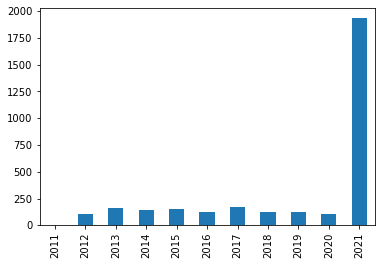

In [161]:
# companies_survived["most_recent_filling"].dt.year.value_counts().sort_index()

companies_survived["most_recent_filling"].dt.year.value_counts().sort_index().plot.bar()

<AxesSubplot:>

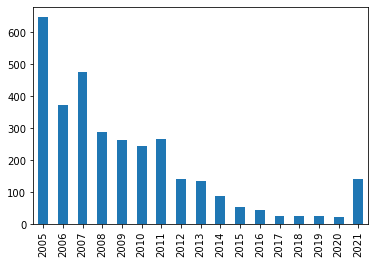

In [163]:
companies_died["most_recent_filling"].dt.year.value_counts().sort_index().plot.bar()

In [4]:
# read anc combine

companies_died = pd.read_csv(
    "../data/intermediate/companies_died_with_subm.csv", index_col=0
)
companies_survived = pd.read_csv(
    "../data/intermediate/companies_survived_with_subm.csv", index_col=0
)

In [5]:
companies = pd.concat([companies_died, companies_survived])
companies["most_recent_filling"] = pd.to_datetime(companies["most_recent_filling"])
companies.columns

Index(['Company Name', 'CIK', 'submissions', 'former_names', 'filings',
       'recent_filings', 'most_recent_filling'],
      dtype='object')

In [267]:
companies.head()

,Company Name,CIK,submissions,former_names,filings,recent_filings,most_recent_filling
0,1 800 CONTACTS INC,1050122,"{'cik': '1050122', 'entityType': 'operating', ...",[],{'recent': {'accessionNumber': ['0001193125-08...,"{'accessionNumber': ['0001193125-08-028302', '...",2008-02-13
1,1ST STATE BANCORP INC,1074078,"{'cik': '1074078', 'entityType': 'operating', ...",[],{'recent': {'accessionNumber': ['0001280529-08...,"{'accessionNumber': ['0001280529-08-000006', '...",2008-02-13
2,24/7 REAL MEDIA INC,1062195,"{'cik': '1062195', 'entityType': 'operating', ...","[{'name': '24/7 MEDIA INC', 'from': '1998-07-2...",{'recent': {'accessionNumber': ['0001354457-07...,"{'accessionNumber': ['0001354457-07-000205', '...",2007-07-12
3,3CI COMPLETE COMPLIANCE CORP,883787,"{'cik': '883787', 'entityType': 'operating', '...",[],{'recent': {'accessionNumber': ['0000950137-06...,"{'accessionNumber': ['0000950137-06-004961', '...",2006-04-26
4,3COM CORP,738076,"{'cik': '738076', 'entityType': 'operating', '...",[],{'recent': {'accessionNumber': ['0001013594-11...,"{'accessionNumber': ['0001013594-11-000064', '...",2011-02-14


In [6]:
companies_minimal = companies[["Company Name", "CIK", "most_recent_filling"]]

In [7]:
companies.to_csv("../data/intermediate/companies_filling.csv")
companies_minimal.to_csv("../data/intermediate/companies_filling_minimal.csv")

<AxesSubplot:>

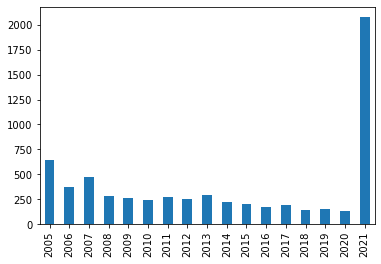

In [270]:
companies_minimal["most_recent_filling"].dt.year.value_counts().sort_index().plot.bar()

In [271]:
companies_minimal.shape

(6409, 3)